# Probablistic model building genetic algorithm

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
from src.model_spaces import get_sim_model_space as get_model_space
from src.neural_search import search_env, get_reward_pipeline
#from src.data import get_sim_deplete_data as get_data
from src.runAmber_simkinn import get_data
from src.reload import reload_from_dir

Using TensorFlow backend.


0.1.2


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
data_fp = "data/sim_data/22-06-28_synth_data_depl/test_1_depl.tsv"
param_fp = "data/sim_data/22-06-28_synth_data_depl/params.yaml"
logbase = 10
(x_train, y_train), (x_test, y_test) = get_data(fp=data_fp, logbase=logbase)

In [5]:
x_train.shape

(16000, 50, 4)

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.2


In [7]:
kinn_model_space = get_model_space(use_sink_state=False)
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50, # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
            ewa_beta=0.9,  # ewa_beta approximates the moving average over 1/(1-ewa_beta) prev points
        )

## A For-Loop that does the work for `amber.architect.trainEnv`

In [9]:
wd = "outputs/notebook"
# trainEnv parameters
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
    samps_per_gen = 5,   # how many arcs to sample in each generation; important
    max_gen = 300,
    patience = 300,
    n_warmup_gen = 0,
    train_data = (x_train, y_train),
    test_data = (x_test, y_test)
)

# manager configs
# this learning rate is trickier than usual, for eigendecomp to work
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5*int(16000/1000), # decrease every 5 epochs
    decay_rate=0.9,
    staircase=True)

if logbase is None:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: x, name="output_nominal")
else:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(x)/np.log(logbase), name="output_log")

manager_kwargs={
    'optimizer': lambda: tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    'output_op': output_op,
    'n_feats': 50,
    'n_channels': 4,
    'batch_size': 1000,
    'epochs': 30,
    'earlystop': 5,
    'verbose': 0
}

In [10]:
controller, hist, stat_df = search_env(
    controller=controller, 
    wd = wd,
    evo_params=evo_params, 
    manager_kwargs=manager_kwargs
)

datapoints:  3 / total:  5
[11:48:01] Gen 0 - Mean fitness 0.540 - Best 0.6433 - PostVar 5.540 - Time 22.06
datapoints:  6 / total:  10
[11:48:23] Gen 1 - Mean fitness 0.543 - Best 0.6593 - PostVar 5.041 - Time 21.73
datapoints:  10 / total:  15
[11:48:45] Gen 2 - Mean fitness 0.551 - Best 0.7003 - PostVar 5.372 - Time 22.65
datapoints:  14 / total:  20
[11:49:09] Gen 3 - Mean fitness 0.560 - Best 0.7135 - PostVar 5.108 - Time 23.28
datapoints:  19 / total:  25
[11:49:32] Gen 4 - Mean fitness 0.568 - Best 0.7135 - PostVar 5.028 - Time 23.04
datapoints:  23 / total:  30
[11:49:54] Gen 5 - Mean fitness 0.571 - Best 0.7180 - PostVar 5.012 - Time 22.46
datapoints:  27 / total:  35
[11:50:17] Gen 6 - Mean fitness 0.575 - Best 0.7527 - PostVar 4.786 - Time 22.63
datapoints:  31 / total:  40
[11:50:39] Gen 7 - Mean fitness 0.579 - Best 0.7527 - PostVar 4.932 - Time 21.98
datapoints:  33 / total:  45
[11:51:03] Gen 8 - Mean fitness 0.591 - Best 0.7642 - PostVar 5.163 - Time 23.58
datapoints:  

datapoints:  127 / total:  250
[12:17:53] Gen 74 - Mean fitness 0.732 - Best 0.8350 - PostVar 5.130 - Time 25.53
datapoints:  129 / total:  250
[12:18:18] Gen 75 - Mean fitness 0.731 - Best 0.8350 - PostVar 4.388 - Time 24.82
datapoints:  126 / total:  250
[12:18:44] Gen 76 - Mean fitness 0.733 - Best 0.8350 - PostVar 4.551 - Time 25.63
datapoints:  124 / total:  250
[12:19:10] Gen 77 - Mean fitness 0.735 - Best 0.8350 - PostVar 4.511 - Time 25.79
datapoints:  121 / total:  250
[12:19:35] Gen 78 - Mean fitness 0.738 - Best 0.8350 - PostVar 4.653 - Time 25.48
datapoints:  124 / total:  250
[12:20:00] Gen 79 - Mean fitness 0.738 - Best 0.8350 - PostVar 4.633 - Time 24.68
datapoints:  124 / total:  250
[12:20:25] Gen 80 - Mean fitness 0.738 - Best 0.8350 - PostVar 4.756 - Time 24.72
datapoints:  120 / total:  250
[12:20:50] Gen 81 - Mean fitness 0.739 - Best 0.8350 - PostVar 4.662 - Time 25.28
datapoints:  122 / total:  250
[12:21:15] Gen 82 - Mean fitness 0.740 - Best 0.8350 - PostVar 4.

datapoints:  101 / total:  250
[12:48:47] Gen 147 - Mean fitness 0.772 - Best 0.8523 - PostVar 4.024 - Time 26.81
datapoints:  101 / total:  250
[12:49:13] Gen 148 - Mean fitness 0.775 - Best 0.8523 - PostVar 4.439 - Time 25.78
datapoints:  103 / total:  250
[12:49:38] Gen 149 - Mean fitness 0.774 - Best 0.8523 - PostVar 4.295 - Time 25.36
datapoints:  99 / total:  250
[12:50:03] Gen 150 - Mean fitness 0.775 - Best 0.8523 - PostVar 4.043 - Time 25.11
datapoints:  100 / total:  250
[12:50:29] Gen 151 - Mean fitness 0.775 - Best 0.8523 - PostVar 4.189 - Time 25.93
datapoints:  95 / total:  250
[12:50:54] Gen 152 - Mean fitness 0.776 - Best 0.8523 - PostVar 4.337 - Time 25.03
datapoints:  107 / total:  250
[12:51:21] Gen 153 - Mean fitness 0.773 - Best 0.8523 - PostVar 4.108 - Time 26.51
datapoints:  91 / total:  250
[12:51:46] Gen 154 - Mean fitness 0.778 - Best 0.8796 - PostVar 4.131 - Time 24.85
datapoints:  91 / total:  250
[12:52:11] Gen 155 - Mean fitness 0.779 - Best 0.8796 - PostV

datapoints:  127 / total:  250
[13:19:11] Gen 219 - Mean fitness 0.794 - Best 0.8796 - PostVar 3.746 - Time 25.86
datapoints:  126 / total:  250
[13:19:36] Gen 220 - Mean fitness 0.795 - Best 0.8796 - PostVar 3.690 - Time 25.21
datapoints:  135 / total:  250
[13:20:01] Gen 221 - Mean fitness 0.792 - Best 0.8796 - PostVar 3.906 - Time 24.68
datapoints:  138 / total:  250
[13:20:26] Gen 222 - Mean fitness 0.792 - Best 0.8796 - PostVar 3.670 - Time 25.07
datapoints:  154 / total:  250
[13:20:51] Gen 223 - Mean fitness 0.788 - Best 0.8796 - PostVar 3.562 - Time 24.98
datapoints:  152 / total:  250
[13:21:17] Gen 224 - Mean fitness 0.787 - Best 0.8796 - PostVar 4.102 - Time 25.65
datapoints:  154 / total:  250
[13:21:42] Gen 225 - Mean fitness 0.787 - Best 0.8796 - PostVar 3.998 - Time 25.17
datapoints:  157 / total:  250
[13:22:07] Gen 226 - Mean fitness 0.784 - Best 0.8796 - PostVar 4.082 - Time 25.16
datapoints:  153 / total:  250
[13:22:32] Gen 227 - Mean fitness 0.786 - Best 0.8796 - P

datapoints:  144 / total:  250
[13:52:05] Gen 291 - Mean fitness 0.799 - Best 0.8899 - PostVar 3.907 - Time 24.84
datapoints:  141 / total:  250
[13:52:31] Gen 292 - Mean fitness 0.799 - Best 0.8899 - PostVar 3.666 - Time 25.36
datapoints:  140 / total:  250
[13:52:57] Gen 293 - Mean fitness 0.800 - Best 0.8899 - PostVar 3.602 - Time 25.72
datapoints:  142 / total:  250
[13:53:22] Gen 294 - Mean fitness 0.800 - Best 0.8899 - PostVar 3.758 - Time 25.72
datapoints:  142 / total:  250
[13:53:48] Gen 295 - Mean fitness 0.800 - Best 0.8899 - PostVar 3.693 - Time 25.44
datapoints:  144 / total:  250
[13:54:14] Gen 296 - Mean fitness 0.800 - Best 0.8899 - PostVar 3.305 - Time 25.76
datapoints:  137 / total:  250
[13:54:40] Gen 297 - Mean fitness 0.804 - Best 0.8899 - PostVar 3.727 - Time 25.76
datapoints:  132 / total:  250
[13:55:05] Gen 298 - Mean fitness 0.806 - Best 0.8899 - PostVar 3.907 - Time 25.26
datapoints:  142 / total:  250
[13:55:31] Gen 299 - Mean fitness 0.804 - Best 0.8899 - P

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


In [11]:
pd.DataFrame(hist).sort_values('test_reward', ascending=False).head()

,gen,arc,test_reward,rate_df
1142,228,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.889860,None
1275,255,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.884414,None
1294,258,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.883785,None
774,154,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.879587,None
1270,254,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.877975,None


In [12]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_reward', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 5}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 8}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 15, 'RANGE_D': 9}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 24, 'RANGE_D': 6}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'EDGE': 1, 'RANGE_ST': 25, 'RANGE_D': 7}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 30, 'RANGE_D': 5}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 35, 'RANGE_D': 5, 'CONTRIB': 1}


In [13]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

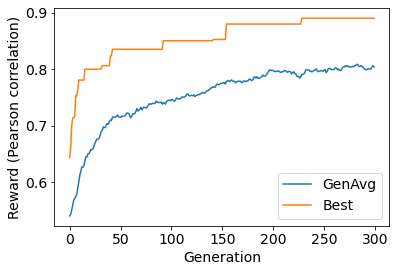

In [14]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

In [15]:
# ground truth
plot_gt = True
with open(param_fp, "r") as f:
    gt_model_params = yaml.load(f, Loader=yaml.Loader)
gt_model_params = modelParams_to_modelSpace(gt_model_params)
gt_rates = [k for k in gt_model_params['Rates']]

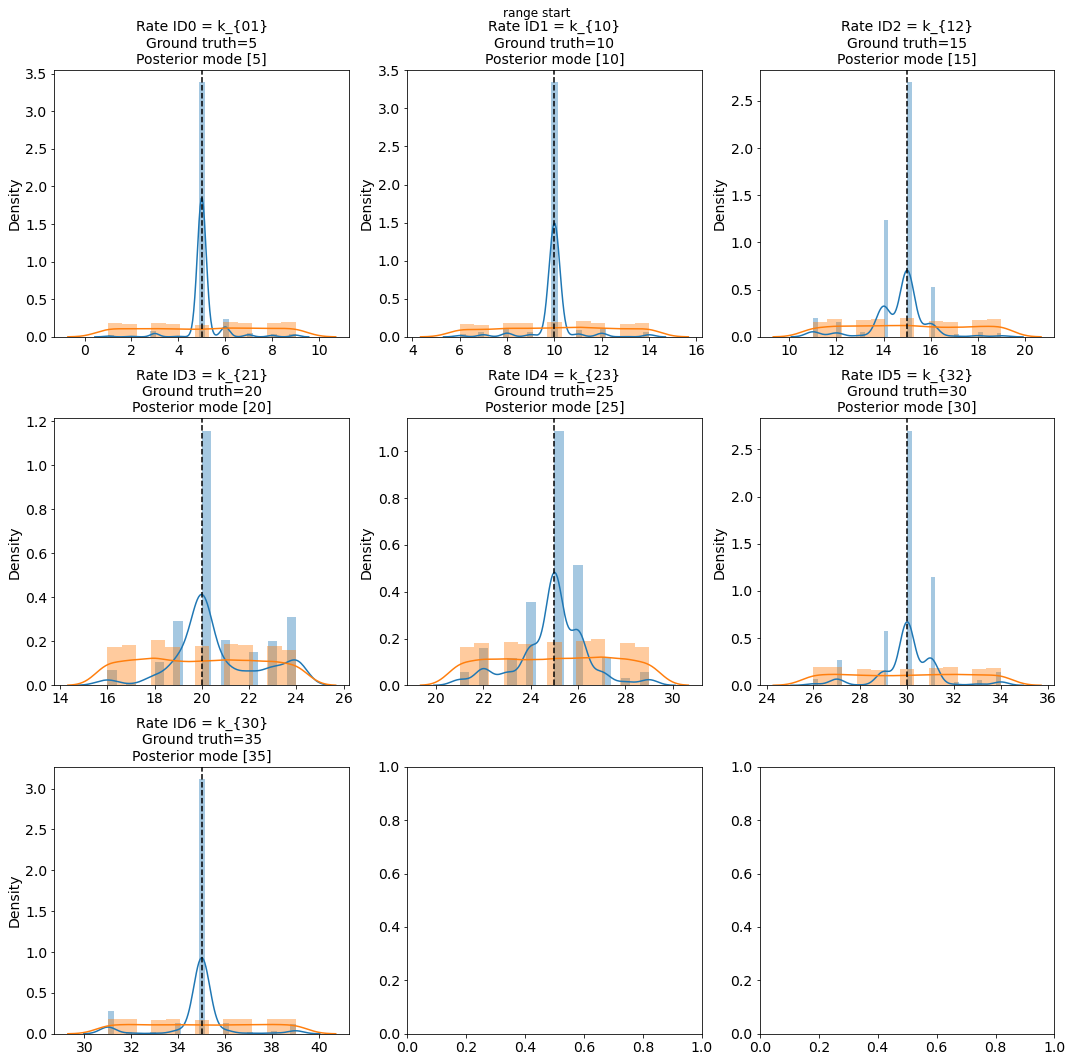

In [16]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_ST'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_ST"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')
            

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

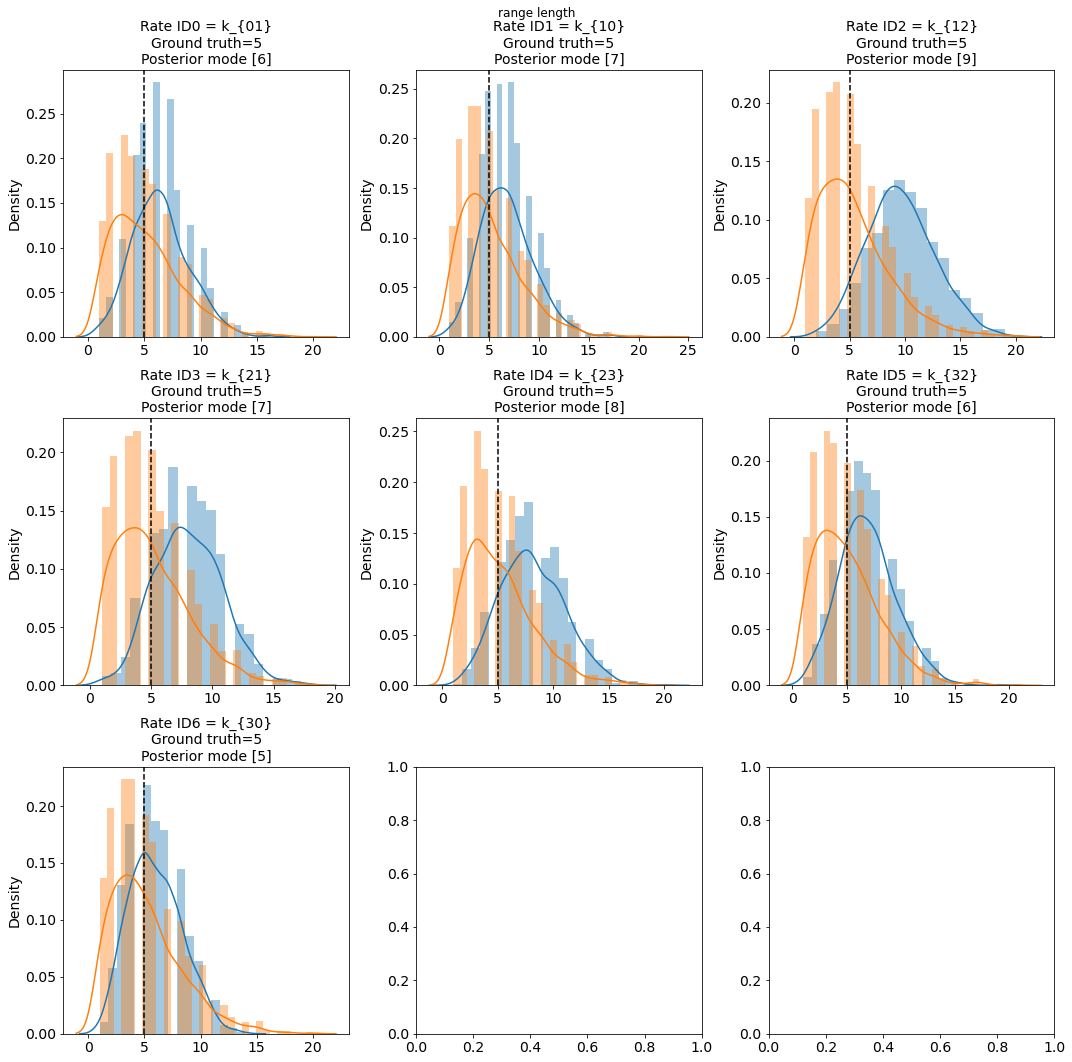

In [17]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_D'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_D"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')

fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

In [18]:
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
tf.compat.v1.reset_default_graph()
tf.compat.v1.experimental.output_all_intermediates(True)
sess = tf.compat.v1.Session()
mb = reload_from_dir(
    wd="outputs/notebook", 
    manager_kwargs=manager_kwargs,
    sess=sess,
    model_fn=KineticNeuralNetworkBuilder)
model = mb.model

loaded searched model


In [19]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [5, 10], 'kernel_size': 1, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 5, 'template': None, 'mat': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [10, 18], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 8, 'template': None, 'mat': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [15, 24], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 15, 'RANGE_D': 9, 'template': None, 'mat': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [24, 30], 'kernel_size': 1, 'scatter_nd': [((2, 2), -1), ((1, 2), 1)], 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 24, 'RANGE_D': 6, 'template': None, 'mat': None}",
 "{'na

In [20]:
layer_dict = {l.name:l for l in model.layers}

In [21]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[-0.662],
        [-0.109],
        [ 0.019],
        [ 0.419]]], dtype=float32)

In [22]:
np.around(layer_dict['conv_k1'].get_weights()[0],3)

array([[[ 0.187],
        [ 0.102],
        [-0.35 ],
        [ 0.413]]], dtype=float32)

spearman SpearmanrResult(correlation=0.8855015189791028, pvalue=0.0)
pearson (0.8898596642135597, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.890')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


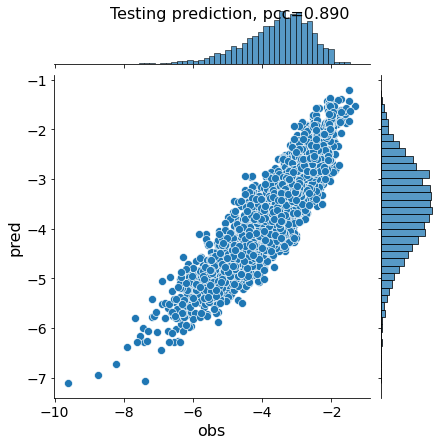

In [23]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

pandas    : 1.3.5
amber     : 0.1.2
tensorflow: 1.15.0
seaborn   : 0.11.1
numpy     : 1.21.6
yaml      : 5.4.1
matplotlib: 3.4.3
scipy     : 1.7.3

Watermark: 2.3.1

